In [1]:
# Import necessary libraries
import urllib.request
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as confusion_matrix
import time
import sqlite3


# Model Implementation

**Dataset Details**:
This dataset captures patterns and behaviours that indicate fraud (victims) or attempted fraud reported from 2021 to 2025. The data is composed of several features designed to reflect the transactional patterns, such as geographical location, gender, age range, complaint type, solicitation method, fraud categories and dollar loss relative to the user.

*   Number ID: *serial number of reported event.*
*   Date received: *The date it was reported.*
*   Complaint Received Type: *How was the complaint made to the government fraud agencies.*
*   Country: This includes multiple countries where Canadians reported from. **Our focus is on Canada only,** hence we filtered this out in our query.
*   Province: *This is the Province in Canada where it was reported from.*
*   Fraud and Cybercrime Thematic Categories: *These are the various fraud categories like Merchandise, Counterfeit Merchandise, Vendor fraud and others.*
*   Solicitation method: *such as text message, email, direct call, internet -social network. *
*   Gender: *Male, Female, Prefer not to say, Not Available*
*   Language: *English or French*
*   Victim Age range: *the age range of victims of fraud or attempted fraud (no fraud).*
*   Complaint Type: *Victim - Fraud (1) and Attempt & Other - No Fraud (0).*
*   Number of Victims: *Victim is reprsented by 1 and all others as 0.*
*   Dollar Loss: *The financial loss implication of fraud as victims*


**Objective of Case study**
- Train the model to know when there is Fraud or No Fraud. No Fraud includes an attempt, other or unknown. As code enforcers, we assumed these three categories as 'No Fraud'. We inncluded Optimization of the KNN model.

- **Additional:** Decided to build a predictive interactive model for users. This model is running on victims only that reported fraud in Canada and will tell the user a situation where there is a possiblity of financial loss.


# Accessing a Dataset through the API

In [2]:
# Configuration for getting data from the API
resource_id = "43c67af5-e598-4a9b-a484-fe1cb5d775b5"  # dataset name
batch_size = 1000  # Maximum allowed per API call
all_records = []
offset = 0
#Fetching the data
while True:
    url = f"https://open.canada.ca/data/en/api/3/action/datastore_search?resource_id={resource_id}&limit={batch_size}&offset={offset}"
    try:
        response = urllib.request.urlopen(url)
        data = json.loads(response.read())
        records = data['result']['records']
        
        if not records:
            break
        
        all_records.extend(records)
        offset += batch_size
        
        # print progress every 10,000 records since it is a big data set
        if offset % 10000 == 0:
            print(f"Downloaded: {offset} records")
        
        time.sleep(0.2)  # delay between batches to avoid over saturating the server

    except Exception as e:
        print(f"Error at offset {offset}: {e}")
        break

Downloaded: 10000 records
Downloaded: 20000 records
Downloaded: 30000 records
Downloaded: 40000 records
Downloaded: 50000 records
Downloaded: 60000 records
Downloaded: 70000 records
Downloaded: 80000 records
Downloaded: 90000 records
Downloaded: 100000 records
Downloaded: 110000 records
Downloaded: 120000 records
Downloaded: 130000 records
Downloaded: 140000 records
Downloaded: 150000 records
Downloaded: 160000 records
Downloaded: 170000 records
Downloaded: 180000 records
Downloaded: 190000 records
Downloaded: 200000 records
Downloaded: 210000 records
Downloaded: 220000 records
Downloaded: 230000 records
Downloaded: 240000 records
Downloaded: 250000 records
Downloaded: 260000 records
Downloaded: 270000 records
Downloaded: 280000 records
Downloaded: 290000 records
Downloaded: 300000 records
Downloaded: 310000 records
Downloaded: 320000 records


In [3]:
df1 = pd.DataFrame.from_records(all_records)
df1.columns

Index(['_id', 'Numero d'identification / Number ID',
       'Date Received / Date recue', 'Complaint Received Type',
       'Type de plainte recue', 'Country', 'Pays', 'Province/State',
       'Province/Etat', 'Fraud and Cybercrime Thematic Categories',
       'Categories thematiques sur la fraude et la cybercriminalite',
       'Solicitation Method', 'Methode de sollicitation', 'Gender', 'Genre',
       'Language of Correspondence', 'Langue de correspondance',
       'Victim Age Range / Tranche d'age des victimes', 'Complaint Type',
       'Type de plainte', 'Number of Victims / Nombre de victimes',
       'Dollar Loss /pertes financieres'],
      dtype='object')

# Prep the data - data cleaning

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328649 entries, 0 to 328648
Data columns (total 22 columns):
 #   Column                                                       Non-Null Count   Dtype 
---  ------                                                       --------------   ----- 
 0   _id                                                          328649 non-null  int64 
 1   Numero d'identification / Number ID                          328649 non-null  object
 2   Date Received / Date recue                                   328649 non-null  object
 3   Complaint Received Type                                      328649 non-null  object
 4   Type de plainte recue                                        328649 non-null  object
 5   Country                                                      328649 non-null  object
 6   Pays                                                         328649 non-null  object
 7   Province/State                                               328649 non-nu

In [5]:
# Drop unnecessary columns
df1 = df1.drop(columns=['_id',
    'Type de plainte recue', 'Pays', 'Province/Etat',
    'Categories thematiques sur la fraude et la cybercriminalite',
    'Methode de sollicitation', 'Genre', 'Langue de correspondance', 'Type de plainte'
])
df1.dtypes

Numero d'identification / Number ID              object
Date Received / Date recue                       object
Complaint Received Type                          object
Country                                          object
Province/State                                   object
Fraud and Cybercrime Thematic Categories         object
Solicitation Method                              object
Gender                                           object
Language of Correspondence                       object
Victim Age Range / Tranche d'age des victimes    object
Complaint Type                                   object
Number of Victims / Nombre de victimes           object
Dollar Loss /pertes financieres                  object
dtype: object

In [6]:
#Changing Numero d'identification / Number ID and Number of Victims / Nombre de victimes format 
df1[["Numero d'identification / Number ID", "Number of Victims / Nombre de victimes"]] = df1[["Numero d'identification / Number ID", "Number of Victims / Nombre de victimes"]].apply(pd.to_numeric).astype('int64')
#Printing type to verify
df1.dtypes

Numero d'identification / Number ID               int64
Date Received / Date recue                       object
Complaint Received Type                          object
Country                                          object
Province/State                                   object
Fraud and Cybercrime Thematic Categories         object
Solicitation Method                              object
Gender                                           object
Language of Correspondence                       object
Victim Age Range / Tranche d'age des victimes    object
Complaint Type                                   object
Number of Victims / Nombre de victimes            int64
Dollar Loss /pertes financieres                  object
dtype: object

In [7]:
#Changing and removing $ from Dollar Loss /pertes financieres column
df1["Dollar Loss /pertes financieres"] = (
    df1['Dollar Loss /pertes financieres']
    .replace('[$,]', '', regex=True)  # No need for backslash before $
    .astype(float)
)
df1.dtypes

Numero d'identification / Number ID                int64
Date Received / Date recue                        object
Complaint Received Type                           object
Country                                           object
Province/State                                    object
Fraud and Cybercrime Thematic Categories          object
Solicitation Method                               object
Gender                                            object
Language of Correspondence                        object
Victim Age Range / Tranche d'age des victimes     object
Complaint Type                                    object
Number of Victims / Nombre de victimes             int64
Dollar Loss /pertes financieres                  float64
dtype: object

In [8]:
# Fill NA values with 'Unknown'
df1 = df1.fillna('Unknown')

# Display the first few rows of the cleaned dataset
df1.head()

,Numero d'identification / Number ID,Date Received / Date recue,Complaint Received Type,Country,Province/State,Fraud and Cybercrime Thematic Categories,Solicitation Method,Gender,Language of Correspondence,Victim Age Range / Tranche d'age des victimes,Complaint Type,Number of Victims / Nombre de victimes,Dollar Loss /pertes financieres
0,1,2021-01-02,CAFC Website,Canada,Saskatchewan,Merchandise,Other/unknown,Not Available,Not Available,'Not Available / non disponible,Attempt,0,0.00
1,2,2021-01-02,CAFC Website,Not Specified,Not Specified,Merchandise,Internet,Not Available,Not Available,'Not Available / non disponible,Victim,1,1000.00
2,3,2021-01-02,CAFC Website,Canada,Quebec,Identity Fraud,Other/unknown,Male,French,'40 - 49,Victim,1,0.00
3,4,2021-01-02,CAFC Website,Canada,Saskatchewan,Phishing,Email,Male,English,'30 - 39,Victim,1,0.00
4,5,2021-01-02,CAFC Website,Canada,Saskatchewan,Merchandise,Other/unknown,Male,Not Available,'60 - 69,Victim,1,222.73


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328649 entries, 0 to 328648
Data columns (total 13 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Numero d'identification / Number ID            328649 non-null  int64  
 1   Date Received / Date recue                     328649 non-null  object 
 2   Complaint Received Type                        328649 non-null  object 
 3   Country                                        328649 non-null  object 
 4   Province/State                                 328649 non-null  object 
 5   Fraud and Cybercrime Thematic Categories       328649 non-null  object 
 6   Solicitation Method                            328649 non-null  object 
 7   Gender                                         328649 non-null  object 
 8   Language of Correspondence                     328649 non-null  object 
 9   Victim Age Range / Tranche d'age des 

In [10]:
df1 = df1.drop(df1[df1['Complaint Type'] == 'Incomplete'].index)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328176 entries, 0 to 328648
Data columns (total 13 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Numero d'identification / Number ID            328176 non-null  int64  
 1   Date Received / Date recue                     328176 non-null  object 
 2   Complaint Received Type                        328176 non-null  object 
 3   Country                                        328176 non-null  object 
 4   Province/State                                 328176 non-null  object 
 5   Fraud and Cybercrime Thematic Categories       328176 non-null  object 
 6   Solicitation Method                            328176 non-null  object 
 7   Gender                                         328176 non-null  object 
 8   Language of Correspondence                     328176 non-null  object 
 9   Victim Age Range / Tranche d'age des victi

In [12]:
df1 = df1.drop(df1[(df1['Complaint Type'] == 'Unknown') & 
                (df1['Fraud and Cybercrime Thematic Categories'] == 'Unknown')].index)

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 327560 entries, 0 to 328648
Data columns (total 13 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Numero d'identification / Number ID            327560 non-null  int64  
 1   Date Received / Date recue                     327560 non-null  object 
 2   Complaint Received Type                        327560 non-null  object 
 3   Country                                        327560 non-null  object 
 4   Province/State                                 327560 non-null  object 
 5   Fraud and Cybercrime Thematic Categories       327560 non-null  object 
 6   Solicitation Method                            327560 non-null  object 
 7   Gender                                         327560 non-null  object 
 8   Language of Correspondence                     327560 non-null  object 
 9   Victim Age Range / Tranche d'age des victi

In [14]:
df1 = df1.rename(columns={
    "Numero d'identification / Number ID": "Number ID",
    "Date Received / Date recue": "Date Received",
    "Victim Age Range / Tranche d'age des victimes": "Victim Age Range",
    "Number of Victims / Nombre de victimes": "Number of Victims",
    "Dollar Loss /pertes financieres": "Dollar Loss"    
})


In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 327560 entries, 0 to 328648
Data columns (total 13 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Number ID                                 327560 non-null  int64  
 1   Date Received                             327560 non-null  object 
 2   Complaint Received Type                   327560 non-null  object 
 3   Country                                   327560 non-null  object 
 4   Province/State                            327560 non-null  object 
 5   Fraud and Cybercrime Thematic Categories  327560 non-null  object 
 6   Solicitation Method                       327560 non-null  object 
 7   Gender                                    327560 non-null  object 
 8   Language of Correspondence                327560 non-null  object 
 9   Victim Age Range                          327560 non-null  object 
 10  Complaint Type           

# SQLite Database Creation and DataFrame Integration

In [16]:
conn = sqlite3.connect('fraud_data.db')  # Creating a database file
cursor = conn.cursor()

In [17]:
# Create table (if it does not already exist)
cursor.execute("""
    CREATE TABLE IF NOT EXISTS fraud_reports (
        NumberID INTEGER PRIMARY KEY,
        Date Received TEXT,
        Complaint Received Type TEXT,
        Country TEXT,
        Province State TEXT,
        Fraud Cybercrime Thematic Categories TEXT,
        Solicitation Method TEXT,
        Gender TEXT,
        Language of Correspondence TEXT,
        Victim Age Range TEXT,
        ComplaintType TEXT,
        Number of Victims INTEGER,
        Dollar Loss REAL
    )
""")
conn.commit() # Save changes

In [18]:
# Inserting data(df) into the database
df1.to_sql('fraud_reports', conn, if_exists='replace', index=False)

327560

In [19]:
# Commit and close the connection
conn.commit()
conn.close()

# Database query and plotting

In [20]:
### 1️⃣ Connect to SQLite Database and Load Data ###
conn = sqlite3.connect("fraud_data.db")
query = "SELECT * FROM fraud_reports"
df = pd.read_sql(query, conn)
conn.close()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327560 entries, 0 to 327559
Data columns (total 13 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Number ID                                 327560 non-null  int64  
 1   Date Received                             327560 non-null  object 
 2   Complaint Received Type                   327560 non-null  object 
 3   Country                                   327560 non-null  object 
 4   Province/State                            327560 non-null  object 
 5   Fraud and Cybercrime Thematic Categories  327560 non-null  object 
 6   Solicitation Method                       327560 non-null  object 
 7   Gender                                    327560 non-null  object 
 8   Language of Correspondence                327560 non-null  object 
 9   Victim Age Range                          327560 non-null  object 
 10  Complaint Type      

In [22]:
canada_df = df[df["Country"] == "Canada"].copy()

In [23]:
canada_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249076 entries, 0 to 327559
Data columns (total 13 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Number ID                                 249076 non-null  int64  
 1   Date Received                             249076 non-null  object 
 2   Complaint Received Type                   249076 non-null  object 
 3   Country                                   249076 non-null  object 
 4   Province/State                            249076 non-null  object 
 5   Fraud and Cybercrime Thematic Categories  249076 non-null  object 
 6   Solicitation Method                       249076 non-null  object 
 7   Gender                                    249076 non-null  object 
 8   Language of Correspondence                249076 non-null  object 
 9   Victim Age Range                          249076 non-null  object 
 10  Complaint Type           

In [24]:
canada_df.columns

Index(['Number ID', 'Date Received', 'Complaint Received Type', 'Country',
       'Province/State', 'Fraud and Cybercrime Thematic Categories',
       'Solicitation Method', 'Gender', 'Language of Correspondence',
       'Victim Age Range', 'Complaint Type', 'Number of Victims',
       'Dollar Loss'],
      dtype='object')

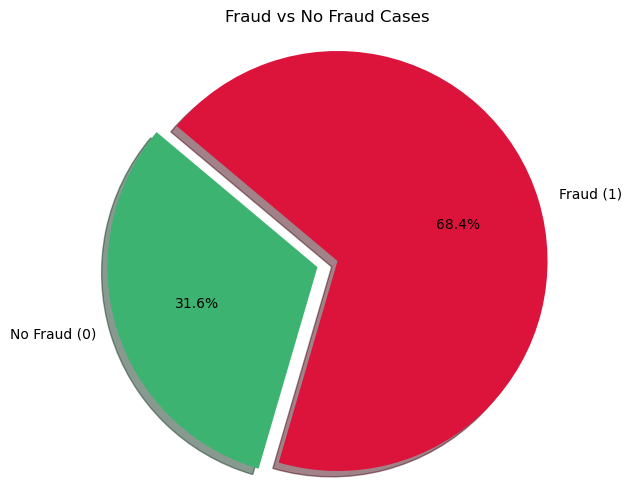

In [25]:
# --- Pie Chart ---
victims = canada_df["Number of Victims"]
victims_counts = victims.value_counts().sort_index()  # 0 = No Fraud, 1 = Fraud
labels = ['No Fraud (0)', 'Fraud (1)']
sizes = victims_counts.values
colors = ["mediumseagreen", "crimson"]
explode = (0, 0.1)  # Emphasize Fraud

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=140, explode=explode, shadow=True)
plt.title("Fraud vs No Fraud Cases")
plt.axis('equal')
plt.savefig("Plot/Fraud vs No Fraud Cases.png", bbox_inches='tight')
plt.show()

In [26]:
# Drop rows where "Number of Victims" is 0 and "Dollar Loss" < 0
victims_df = canada_df[(canada_df["Dollar Loss"] > 0) & (canada_df["Number of Victims"] > 0)]
victims_df

,Number ID,Date Received,Complaint Received Type,Country,Province/State,Fraud and Cybercrime Thematic Categories,Solicitation Method,Gender,Language of Correspondence,Victim Age Range,Complaint Type,Number of Victims,Dollar Loss
4,5,2021-01-02,CAFC Website,Canada,Saskatchewan,Merchandise,Other/unknown,Male,Not Available,'60 - 69,Victim,1,222.73
7,8,2021-01-02,CAFC Website,Canada,British Columbia,Vendor Fraud,Text message,Male,English,'10 - 19,Victim,1,300.00
14,15,2021-01-02,CAFC Website,Canada,Yukon,Spear Phishing,Email,Male,English,'70 - 79,Victim,1,1600.00
35,36,2021-01-02,CAFC Website,Canada,Alberta,Extortion,Internet-social network,Male,English,'40 - 49,Victim,1,24000.00
39,40,2021-01-02,CAFC Website,Canada,Prince Edward Island,Merchandise,Internet,Male,English,'30 - 39,Victim,1,11000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
327539,328629,2025-03-28,Other,Canada,Ontario,Unknown,Other/unknown,Not Available,Not Available,'20 - 29,Victim,1,146.57
327541,328631,2025-03-28,Other,Canada,Quebec,Unknown,Other/unknown,Not Available,Not Available,'30 - 39,Victim,1,826.75
327545,328635,2025-03-28,Other,Canada,Quebec,Other,Other/unknown,Male,French,'30 - 39,Victim,1,70.93
327550,328640,2025-03-28,Phone,Canada,Ontario,Merchandise,Direct call,Male,English,'40 - 49,Victim,1,83.87


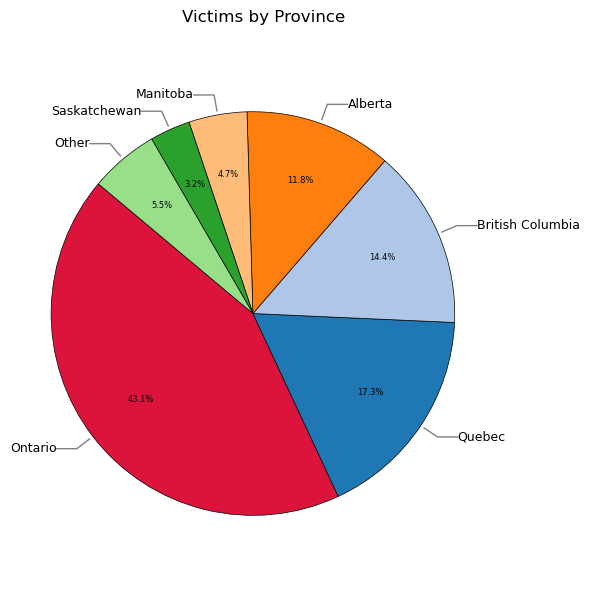

In [27]:
# Pie Chart:  victims by province
# Prepare data
victim_counts = victims_df['Province/State'].value_counts()
total = victim_counts.sum()
threshold = 0.03
victim_counts_pct = victim_counts / total

# Group provinces with counts within threshold under 'Other'
grouped_data = victim_counts[victim_counts_pct > threshold].copy()
grouped_data['Other'] = victim_counts[victim_counts_pct <= threshold].sum()

# Identify the province with the highest count
max_province = grouped_data.idxmax()

# Assign colors: crimson for max, others from tab20
base_colors = list(plt.cm.tab20.colors)
colors = ['crimson' if province == max_province else base_colors.pop(0) for province in grouped_data.index]

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, _, autotexts = ax.pie(
    grouped_data,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'},
    pctdistance=0.7,
    labels=None
)

# Adjust % font size
for autotext in autotexts:
    autotext.set_fontsize(6)
    
# Add province labels with two-segment leader lines
for wedge, province in zip(wedges, grouped_data.index):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))

    # Coordinates at the outer edge of the pie
    start_x = 1.02 * x
    start_y = 1.02 * y

    # Coordinates for the vertical part of the leader line
    middle_x = 1.1 * x
    middle_y = 1.1 * y

    # Coordinates for the label and horizontal line
    horizontal_offset = 0.1
    end_x = middle_x + horizontal_offset if x >= 0 else middle_x - horizontal_offset
    end_y = middle_y

    ha = 'left' if x >= 0 else 'right'

    # Draw the 2-part leader line: vertical then horizontal
    ax.plot([start_x, middle_x, end_x], [start_y, middle_y, end_y], color='gray', lw=1)

    # Annotate the label at the end of the horizontal line
    ax.text(end_x, end_y, province,
            ha=ha, va='center', fontsize=9)

# Add title and adjust layout to avoid overlap
ax.set_title('Victims by Province', fontsize=12)
ax.axis('equal')  # Keep pie chart circular
plt.tight_layout()
plt.savefig("Plot/Victims by Province.png")
plt.show()

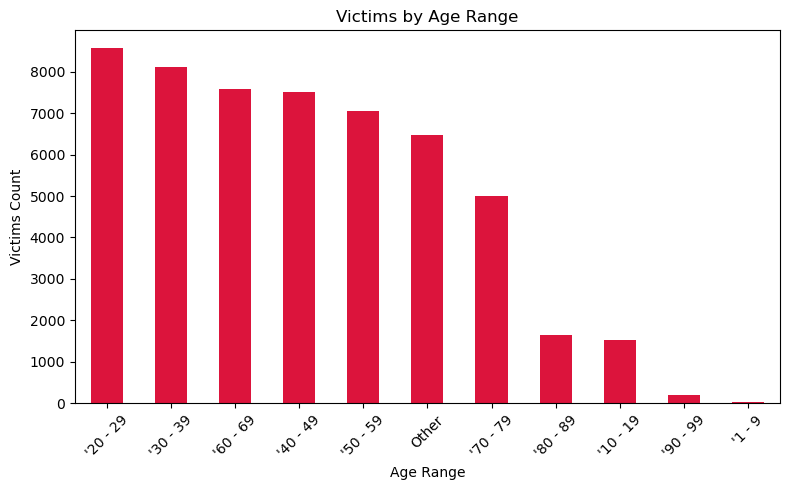

In [28]:
# Bar Plot: Victims by Age Range
# Combine these categories into 'Other'
comb_cat = [
    "'100 +",
    "'Deceased / Décédé",
    "'Business / Entreprise",
    "'Not Available / non disponible"
]

# Replace comb_cat with 'Other'
victims_df.loc[:, 'Victim Age Range'] = victims_df['Victim Age Range'].replace(comb_cat, 'Other')

# Get value counts (default: descending order)
age_range_counts = victims_df['Victim Age Range'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
age_range_counts.plot(kind='bar', color='crimson')
plt.title('Victims by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Victims Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Plot/Victims by Age Range.png")
plt.show()

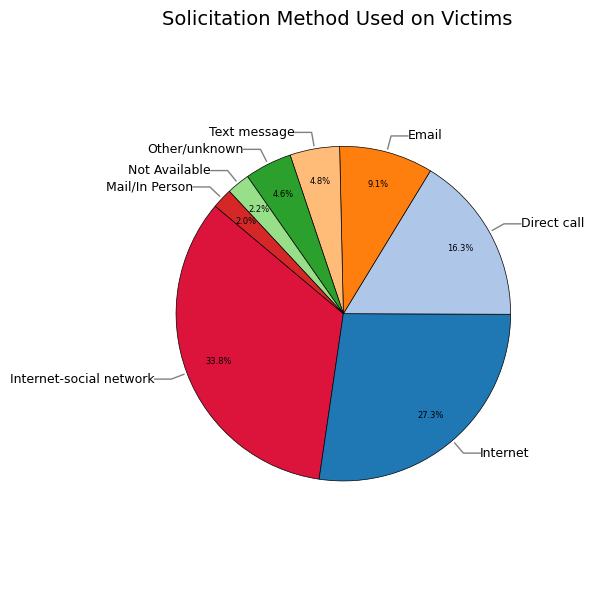

In [29]:
# Pie Chart : Solicitations Used on Victims
# Prepare data
method_counts = victims_df['Solicitation Method'].value_counts()
total = method_counts.sum()
threshold = 0.02
method_pct = method_counts / total

# Group small methods under 'Mail/In Person'
grouped_methods = method_counts[method_pct > threshold].copy()
grouped_methods['Mail/In Person'] = method_counts[method_pct <= threshold].sum()

# Identify the method with the highest count
max_method = grouped_methods.idxmax()

# Assign colors: crimson for max, others from tab20
base_colors = list(plt.cm.tab20.colors)
colors = ['crimson' if method == max_method else base_colors.pop(0) for method in grouped_methods.index]

# Create pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, _, autotexts = ax.pie(
    grouped_methods,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'linewidth': 0.5, 'edgecolor': 'black'},
    pctdistance=0.8,
    labels=None
)

# Adjust % font size
for autotext in autotexts:
    autotext.set_fontsize(6)
    
# Add method labels with two-segment leader lines
for wedge, method in zip(wedges, grouped_methods.index):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))

    # Coordinates at the outer edge of the pie
    start_x = 1.02 * x
    start_y = 1.02 * y

    # Coordinates for the vertical part of the leader line
    middle_x = 1.1 * x
    middle_y = 1.1 * y

    # Coordinates for the label and horizontal line
    horizontal_offset = 0.1
    end_x = middle_x + horizontal_offset if x >= 0 else middle_x - horizontal_offset
    end_y = middle_y

    ha = 'left' if x >= 0 else 'right'

    # Draw the 2-part leader line: vertical then horizontal
    ax.plot([start_x, middle_x, end_x], [start_y, middle_y, end_y], color='gray', lw=1)

    # Annotate the label at the end of the horizontal line
    ax.text(end_x, end_y, method,
            ha=ha, va='center', fontsize=9)

# Add title and adjust layout to avoid overlap
ax.set_title('Solicitation Method Used on Victims', fontsize=14)
ax.axis('equal')  # Keep pie chart circular
plt.tight_layout()
plt.savefig("Plot/Solicitation Method Used on Victims.png")
plt.show()

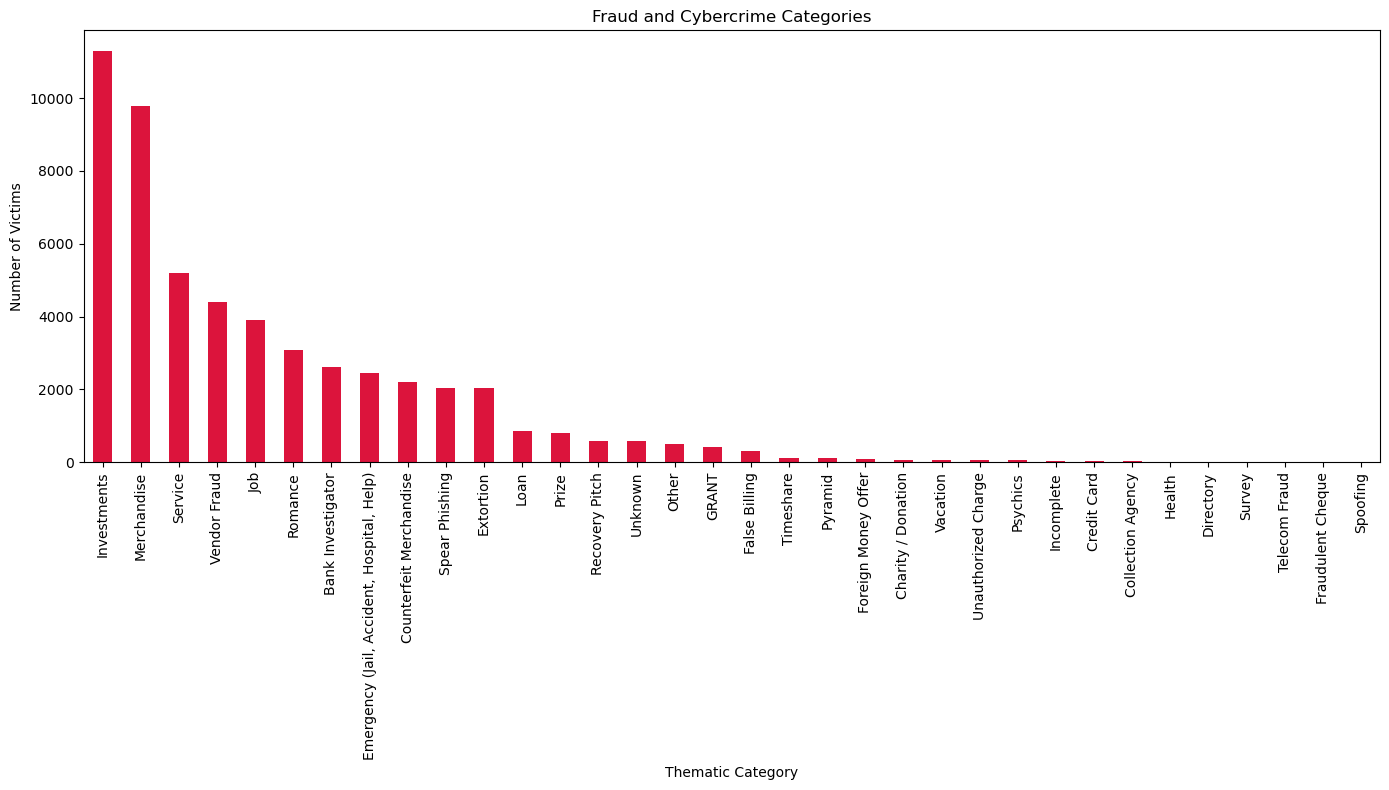

In [30]:
# Bar Chart: Victims by Fraud and Cybercrime Categories
plt.figure(figsize=(14, 8))
victims_df['Fraud and Cybercrime Thematic Categories'].value_counts().plot(
    kind='bar', color='crimson'
)
plt.title('Fraud and Cybercrime Categories')
plt.xlabel('Thematic Category')
plt.ylabel('Number of Victims')
plt.tight_layout()
plt.savefig("Plot/Fraud and Cybercrime Categories.png")
plt.show()

C:\Users\eek_e\AppData\Local\Temp\ipykernel_11196\2592462986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  victims_df['Date Received'] = pd.to_datetime(df['Date Received'], errors='coerce')
C:\Users\eek_e\AppData\Local\Temp\ipykernel_11196\2592462986.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  victims_df['Year'] = victims_df['Date Received'].dt.year


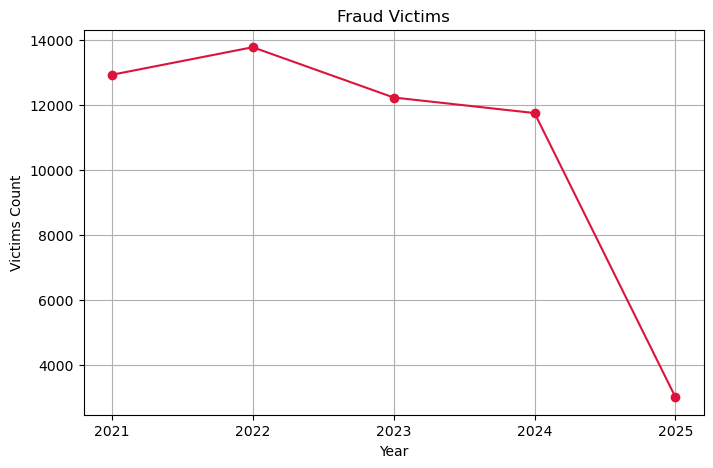

In [31]:
# Extract year from the report date
victims_df['Date Received'] = pd.to_datetime(df['Date Received'], errors='coerce')
victims_df['Year'] = victims_df['Date Received'].dt.year
# Count and sort victims by year
victim_counts = victims_df['Year'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.plot(victim_counts.index, victim_counts.values, marker='o', linestyle='-', color='crimson')
plt.title('Fraud Victims')
plt.xlabel('Year')
plt.ylabel('Victims Count')
# Force x-ticks to be the actual integer years
plt.xticks(ticks=victim_counts.index, labels=victim_counts.index.astype(int))
plt.grid(True)
# plt.tight_layout()
plt.savefig("Plot/Fraud Victims.png", bbox_inches='tight')
plt.show()

C:\Users\eek_e\AppData\Local\Temp\ipykernel_11196\3112765623.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Date Received'] = pd.to_datetime(df2['Date Received'])
C:\Users\eek_e\AppData\Local\Temp\ipykernel_11196\3112765623.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Year'] = df2['Date Received'].dt.year


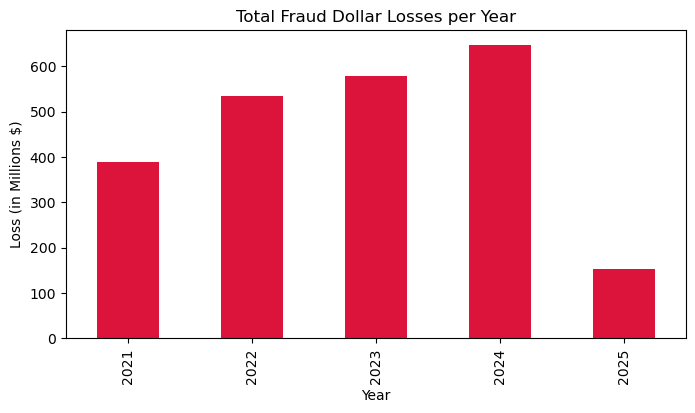

Total Fraud Dollar Losses in Canada (in Millions of CAD):
Year
2021    388.73
2022    533.64
2023    577.76
2024    647.19
2025    152.20
Name: Dollar Loss, dtype: float64


In [32]:
# Bar Chart : Dollor Loss Per Year
# Ensure 'Date received' is in datetime format
df2 = df[df["Number of Victims"] > 0]
df2['Date Received'] = pd.to_datetime(df2['Date Received'])

# Extract the year
df2['Year'] = df2['Date Received'].dt.year

# Group by year, sum dollar losses, and convert to millions
loss_per_year_millions = df2.groupby('Year')['Dollar Loss'].sum() / 1_000_000
loss_per_year_millions = loss_per_year_millions.round(2)

# Plot
plt.figure(figsize=(8, 4))
loss_per_year_millions.plot(kind='bar', color='crimson')
plt.title('Total Fraud Dollar Losses per Year')
plt.xlabel('Year')
plt.ylabel('Loss (in Millions $)')
plt.savefig("Plot/Total Fraud Dollar Losses per Yea.png", bbox_inches='tight')
plt.show()

print("Total Fraud Dollar Losses in Canada (in Millions of CAD):")
print(loss_per_year_millions)

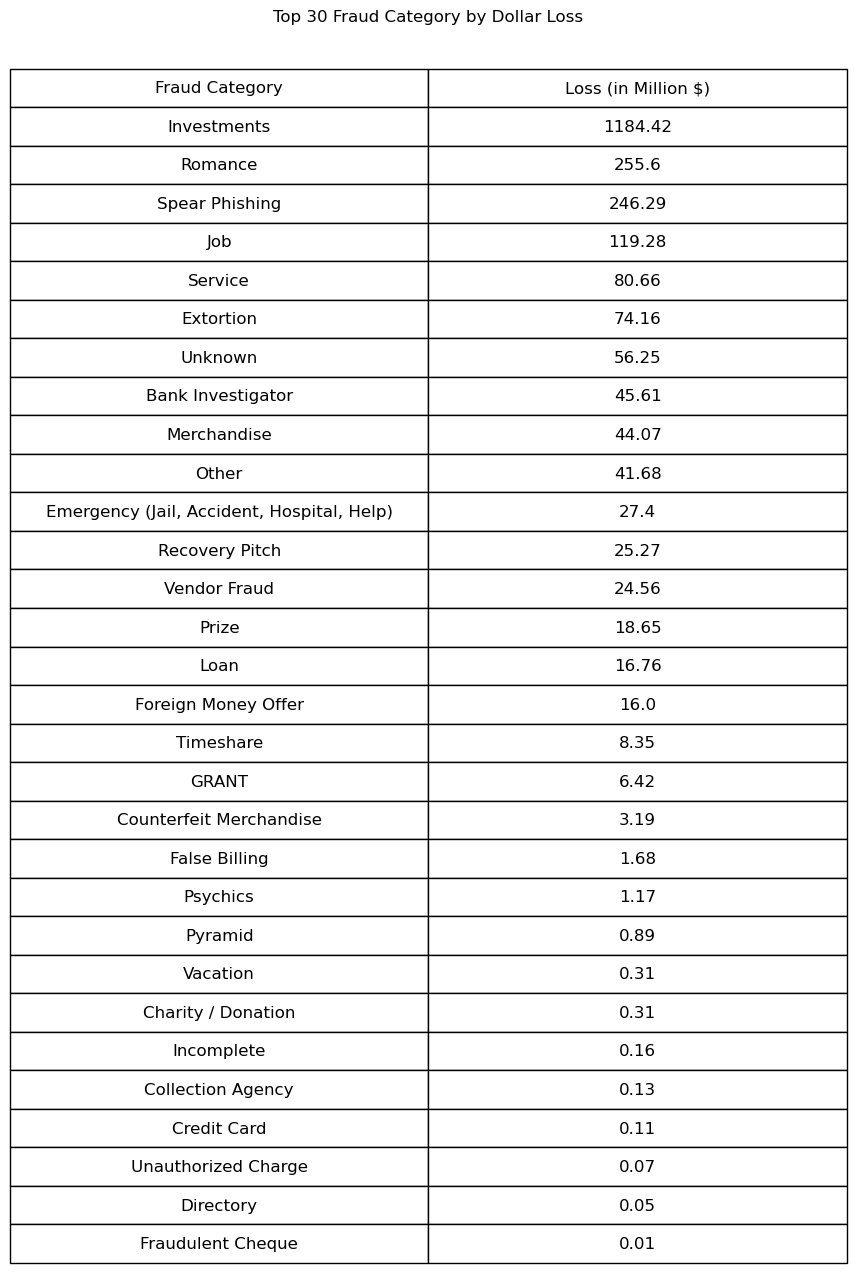

In [33]:
# Table Chart: Dollar Loss by Fraud and Cybercrime Categories
# Clean and convert loss to numeric, then group and prepare data
table_data = (
    df.assign(**{"Dollar Loss": pd.to_numeric(df["Dollar Loss"].astype(str).str.replace("[$,]", "", regex=True), errors='coerce')})
      .groupby("Fraud and Cybercrime Thematic Categories")["Dollar Loss"]
      .sum()
      .div(1_000_000)  # convert to millions
      .round(2)
      .sort_values(ascending=False)
      .head(30)        # select top 30
      .reset_index()
)

table_data.columns = ['Fraud Category', 'Loss (in Million $)']

fig, ax = plt.subplots(figsize=(8, len(table_data)*0.4 + 1))
ax.axis('off')

table = ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)

# Adjust row height: scale horizontally by 1, vertically by 2 (example)
table.scale(1.35, 2)  # Increase vertical scale for taller rows

plt.title('Top 30 Fraud Category by Dollar Loss', y=1.05)
plt.subplots_adjust(top=1.0)  # Reduce gap between title and table
plt.savefig("Plot/Top 30 Fraud Category by Dollar Loss.png", bbox_inches='tight')
plt.show()

# Training the Machine on Part 1 - Fraud vs. No Fraud

Stakeholders:
1. Law Enforcement & Government: Identify high-risk fraud zones and optimize resource allocation.
2. Financial Institutions: Strengthen fraud detection and enhance consumer protection.


In [34]:
# Convert categorical variables to numerical format using Label Encoding
categorical_columns = ["Complaint Received Type", "Country", "Province/State", "Fraud and Cybercrime Thematic Categories", "Solicitation Method", "Gender", "Language of Correspondence","Dollar Loss"]
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    canada_df[col] = label_encoders[col].fit_transform(canada_df[col])

In [35]:
# Feature Selection
X = canada_df.drop(["Number ID","Complaint Type", "Number of Victims"], axis=1)
y = canada_df["Number of Victims"].apply(lambda x: 1 if x > 0 else 0)

In [36]:
# Normalize Data
scaler = StandardScaler()
X_numeric = X.select_dtypes(include=['number'])  # Select only numeric columns
X_scaled = scaler.fit_transform(X_numeric)


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Implementation: Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.5f}")


Model Accuracy: 0.88002


In [37]:
# Save Model Evaluation Data to CSV for Optimization Tracking
evaluation_results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
evaluation_results.to_csv("model_evaluation.csv", index=False)

# Print Performance Metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82     15780
           1       0.94      0.88      0.91     34036

    accuracy                           0.88     49816
   macro avg       0.86      0.88      0.87     49816
weighted avg       0.89      0.88      0.88     49816



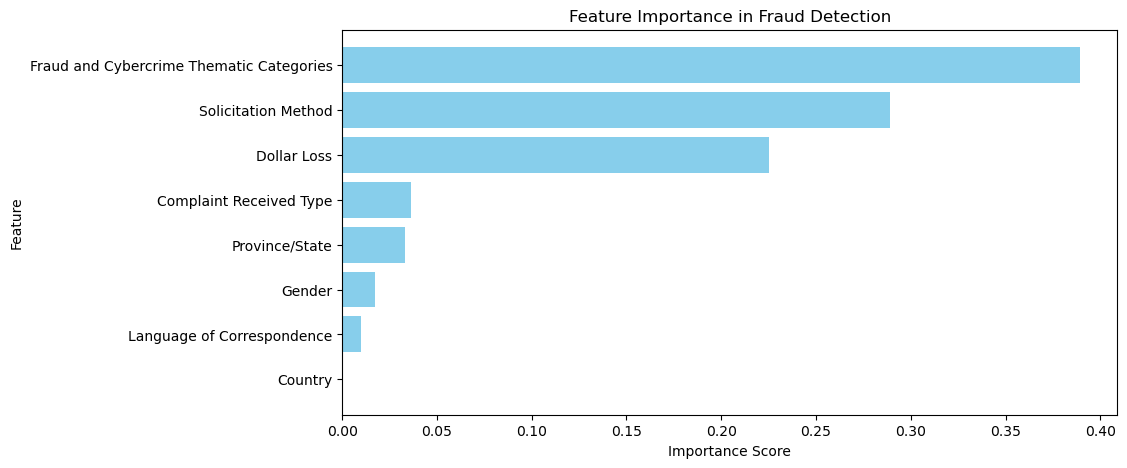

In [38]:
# Get feature importance from the trained model
feature_importance = model.feature_importances_

# Convert to DataFrame for easy plotting
feature_names = X_numeric.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Fraud Detection")
plt.savefig("Plot/Feature Importance in Fraud Detection.png")
plt.show()

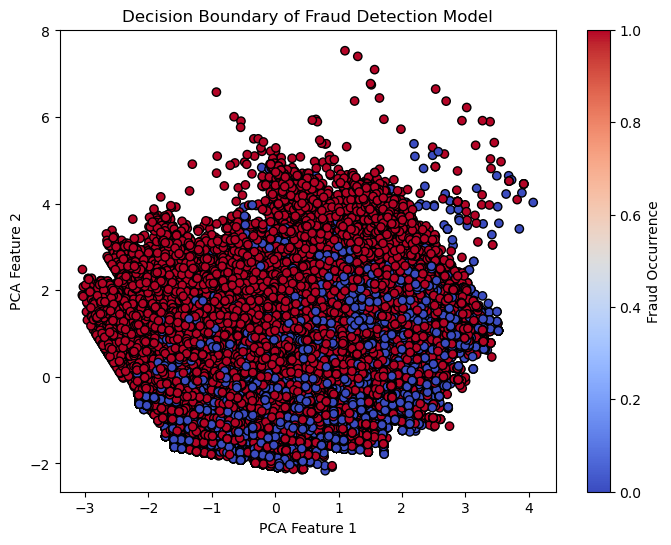

In [39]:
# Reduce feature dimensions using PCA for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot with fraud cases color-coded
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", edgecolors='k')
plt.title("Decision Boundary of Fraud Detection Model")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.colorbar(label="Fraud Occurrence")
plt.savefig("Plot/Decision Boundary of Fraud Detection Model.png")
plt.show()

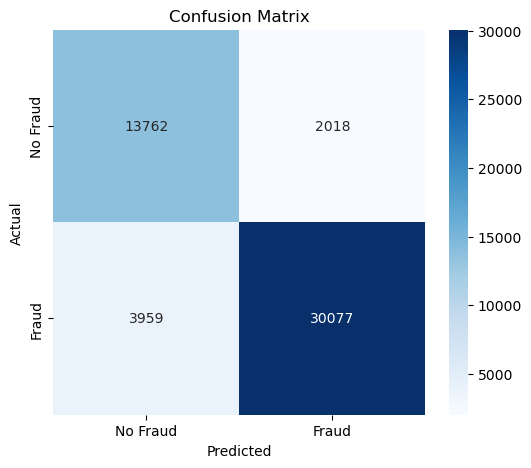

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Plot/Confusion Matrix.png")
plt.show()

# Optimization of Part 1 - Fraud vs. No Fraud

In [41]:
# Create model and fit
knn = KNeighborsClassifier(n_neighbors=5)
knn_model = knn.fit(X_train, y_train)
knn_model

KNeighborsClassifier()

In [42]:
# Predict
knn_testing_prediction = knn_model.predict(X_test)
knn_testing_prediction

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [43]:
knn_accuracy_score = accuracy_score(y_test, knn_testing_prediction)

print(f"The Accuracy score of KNN model at K=5 is : {knn_accuracy_score:.5f}")

The Accuracy score of KNN model at K=5 is : 0.86017


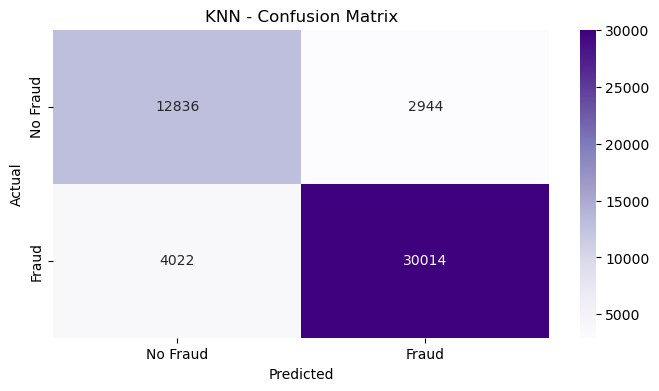

In [44]:
# Create confusion matrix
knn_confustion_matrix_plot = confusion_matrix(y_test, knn_testing_prediction)
plt.figure(figsize=(8, 4))
sns.heatmap(
    knn_confustion_matrix_plot,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["No Fraud", "Fraud"],
    yticklabels=["No Fraud", "Fraud"],
)
plt.title("KNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("Plot/KNN - Confusion Matrix.png")
plt.show()


k: 1, Train/Test Score & Accuracy: 0.85986/0.83871, 0.83871
k: 3, Train/Test Score & Accuracy: 0.87190/0.85639, 0.85639
k: 5, Train/Test Score & Accuracy: 0.87158/0.86017, 0.86017
k: 7, Train/Test Score & Accuracy: 0.87358/0.86466, 0.86466
k: 9, Train/Test Score & Accuracy: 0.87409/0.86603, 0.86603
k: 11, Train/Test Score & Accuracy: 0.87375/0.86791, 0.86791
k: 13, Train/Test Score & Accuracy: 0.87332/0.86906, 0.86906
k: 15, Train/Test Score & Accuracy: 0.87251/0.86771, 0.86771
k: 17, Train/Test Score & Accuracy: 0.87216/0.86739, 0.86739
k: 19, Train/Test Score & Accuracy: 0.87136/0.86838, 0.86838


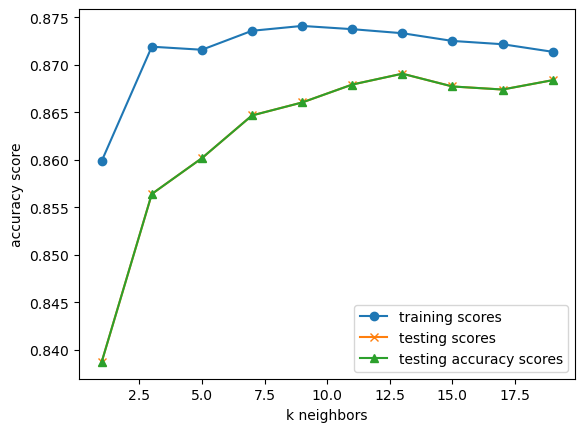

In [45]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
acc_score = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    test_predict = knn.predict(X_test)
    test_accuracy_score = accuracy_score(y_test, test_predict)
    train_scores.append(train_score)
    test_scores.append(test_score)
    acc_score.append(test_accuracy_score)
    print(
        f"k: {k}, Train/Test Score & Accuracy: {train_score:.5f}/{test_score:.5f}, {test_accuracy_score:.5f}"
    )

# Plot the results
plt.plot(range(1, 20, 2), train_scores, marker="o", label="training scores")
plt.plot(range(1, 20, 2), test_scores, marker="x", label="testing scores")
plt.plot(range(1, 20, 2), acc_score, marker="^", label="testing accuracy scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.savefig("Plot/k neighbors vs accuracy score.png")
plt.show()

In [46]:
# Optimized K
knn_optimized = KNeighborsClassifier(n_neighbors=15)
knn_optimized_model = knn_optimized.fit(X_train, y_train)
knn_optimized_model



KNeighborsClassifier(n_neighbors=15)

In [50]:
# Predict using the final trained model (after finding best K)
final_preds = knn_optimized.predict(X_test)

knn_opt_accuracy_score = accuracy_score(y_test, final_preds)

print(f"The Accuracy score of KNN model at K=15 is : {knn_opt_accuracy_score:.5f}")


The Accuracy score of KNN model at K=15 is : 0.86771


In [51]:
# Evaluate performance
from sklearn.metrics import classification_report
print(classification_report(y_test, final_preds))


              precision    recall  f1-score   support

           0       0.76      0.84      0.80     15780
           1       0.92      0.88      0.90     34036

    accuracy                           0.87     49816
   macro avg       0.84      0.86      0.85     49816
weighted avg       0.87      0.87      0.87     49816



# Summary
### Accuracy of 2 models and Optimization

|                          | Random Forest Classifier | K Neighbors Classifier (K=5) | Optimized K Neighbors Classifier (K=15) |
|--------------------------|--------------------------|------------------------------|-------------------------------|
| **Accuracy Score**       | 0.88002                  | 0.86017                     | 0.86771                       |


# Additional:
Note - This is an additional layer to the assignment that the Code Enforcers thought to add. This is still being developed but we have a prototype to predict financial loss of fraud.

 **This will be in an app.py file. Please refer to the file.**